# Exploring Data Augmentation for Trash Classification
### ECE 285: Final Project
#### Merve Kilic
#### A15978640

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pickle
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import os

In [ ]:
path = os.getcwd()
path = path + '/drive/MyDrive/ECE 285: Visual Learning/Project/'



In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Data Preprocessing

In [ ]:
path_data = path + 'dataset-resized/'
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
num_classes = 6
im_size = (384, 512, 3)

In [ ]:
Img_File_Extensions = [
    '.jpg',
    '.JPG',
    '.jpeg',
    '.JPEG',
    '.png',
    '.PNG',
    '.ppm',
    '.PPM',
    '.bmp',
    '.BMP',
    '.tiff',
    '.TIFF',
]


def is_image(file):
    return any(file.endswith(extension) for extension in Img_File_Extensions)

class MyDataloader(torch.utils.data.Dataset):
  def __init__(self,data_root,transforms=None):
    self.files = []
    self.root = data_root
    all_files = os.listdir(data_root)
    self.files = [i for i in all_files if is_image(i)]
    self.transforms = transforms
  def __len__(self):
    return len(self.files)
  def __getitem__(self,idx):
    file = os.path.join(self.root,self.files[idx])
    raw_im = np.array(Image.open(file))
    m = np.nanmean(raw_im)
    raw_im = np.nan_to_num(raw_im,nan=m)
    return raw_im


In [ ]:
for cat in categories:
  dataset = MyDataloader(path_data + cat)
  n_samples = len(dataset)
  data = np.zeros((n_samples, *im_size))
  for i in range(n_samples):
    data[i] = dataset.__getitem__(i)
  print(cat, 'shape: ', data.shape)
  with open(path + 'pickle/' + cat + '.pickle', 'wb') as handle:
    pickle.dump(data, handle)

cardboard shape:  (403, 384, 512, 3)
glass shape:  (501, 384, 512, 3)
metal shape:  (410, 384, 512, 3)
paper shape:  (594, 384, 512, 3)
plastic shape:  (482, 384, 512, 3)
trash shape:  (137, 384, 512, 3)


In [ ]:
n_samples = 403 + 501 + 410 + 594 + 482 + 137
print(f'Total samples: {n_samples}')

Total samples: 2527


In [ ]:
input_data = np.zeros((n_samples, *im_size))
target_data = np.zeros((n_samples, 1))
cur_i = 0
for label, cat in enumerate(categories):
  with open(path + 'pickle/' + cat + '.pickle', 'rb') as handle:
    cur_data = pickle.load(handle)
  cur_n = cur_data.shape[0]
  input_data[cur_i:cur_i + cur_n, :, :, :] = cur_data
  target_data[cur_i:cur_i + cur_n] = np.ones((cur_n,1)) * label
  cur_i += cur_n

with open(path + 'pickle/input_data.pickle', 'wb') as handle:
  pickle.dump(input_data, handle)

with open(path + 'pickle/target_data.pickle', 'wb') as handle:
  pickle.dump(target_data, handle)

In [ ]:
# Load Data
with open(path + 'pickle/input_data.pickle', 'rb') as handle:
    input_data = pickle.load(handle)
with open(path + 'pickle/target_data.pickle', 'rb') as handle:
    target_data = pickle.load(handle)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        # Permute the image tensor dimensions
        x = x.permute(2, 0, 1)

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

Create the dataset
train_dataset = CustomDataset(input_data, target_data)

In [ ]:
with open(path + 'pickle/train_dataset.pickle', 'wb') as handle:
    pickle.dump(train_dataset, handle)

## Define Models

### ResNet
- Pretrained with ImageNet dataset

In [ ]:
# Define the encoder and the decoder
class ResnetEncoder(nn.Module):
    def __init__(self):
        super(ResnetEncoder, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Remove the last layer (fc) from the pretrained ResNet
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        return self.resnet(x)

class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Combine the encoder and decoder into a single model
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.encoder = ResnetEncoder()
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### VGG
- Pretrained with ImageNet dataset

In [ ]:
# Define the encoder and the decoder
class VGGEncoder(nn.Module):
    def __init__(self):
        super(VGGEncoder, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features

    def forward(self, x):
        return self.features(x)

class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Combine the encoder and decoder into a single model
class VGGModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGModel, self).__init__()
        self.encoder = VGGEncoder()
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Classification

### 1. Classification using Vanilla Datasaet

#### ResNet

##### Training

In [ ]:
with open(path + 'pickle/train_dataset.pickle', 'rb') as handle:
    train_dataset = pickle.load(handle)

In [ ]:
# Split 80% for training and 20% for testing
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size

torch.manual_seed(0)
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define model
model = ResNetModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
# Batch size is 32
num_epochs = 30
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[epoch] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


with open(path + 'pickle/vanilla_RN_model.pickle', 'wb') as handle:
    pickle.dump(model, handle)
with open(path + 'pickle/vanilla_RN_loss.pickle', 'wb') as handle:
    pickle.dump(losses, handle)

Epoch [1/30], Loss: 0.5835
Epoch [2/30], Loss: 1.4447
Epoch [3/30], Loss: 1.4549
Epoch [4/30], Loss: 0.8779
Epoch [5/30], Loss: 0.5538
Epoch [6/30], Loss: 1.8794
Epoch [7/30], Loss: 1.6093
Epoch [8/30], Loss: 1.8244
Epoch [9/30], Loss: 2.2939
Epoch [10/30], Loss: 0.7113
Epoch [11/30], Loss: 1.6037
Epoch [12/30], Loss: 1.0270
Epoch [13/30], Loss: 0.9104
Epoch [14/30], Loss: 0.5243
Epoch [15/30], Loss: 1.2034
Epoch [16/30], Loss: 0.2045
Epoch [17/30], Loss: 1.6159
Epoch [18/30], Loss: 1.5789
Epoch [19/30], Loss: 2.6309
Epoch [20/30], Loss: 0.9566
Epoch [21/30], Loss: 2.6671
Epoch [22/30], Loss: 0.9359
Epoch [23/30], Loss: 0.6511
Epoch [24/30], Loss: 0.6111
Epoch [25/30], Loss: 0.8251
Epoch [26/30], Loss: 0.2969
Epoch [27/30], Loss: 1.5537
Epoch [28/30], Loss: 0.6415
Epoch [29/30], Loss: 1.5015
Epoch [30/30], Loss: 2.2059


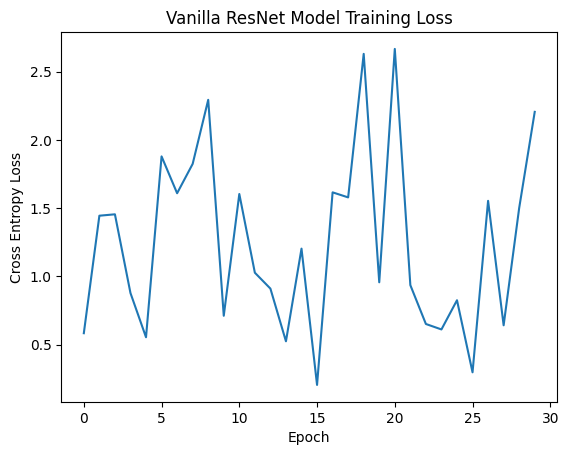

In [ ]:
# Plot Training Loss
# Batch size is 32
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Vanilla ResNet Model Training Loss');

##### Testing

In [ ]:
with open(path + 'pickle/vanilla_RN_model.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
# Batch size is 32
model.eval()  # set the model to evaluation mode

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)

        # Get prediction from max value
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions * 100
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

Accuracy on the test set: 77.27%


#### VGG

##### Training

In [ ]:
with open(path + 'pickle/train_dataset.pickle', 'rb') as handle:
    train_dataset = pickle.load(handle)

In [ ]:
# Split 80% for training and 20% for testing
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size

torch.manual_seed(0)
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define model
model = VGGModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 30
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[epoch] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


with open(path + 'pickle/vanilla_VGG_model.pickle', 'wb') as handle:
    pickle.dump(model, handle)
with open(path + 'pickle/vanilla_VGG_loss.pickle', 'wb') as handle:
    pickle.dump(losses, handle)

Epoch [1/30], Loss: 1.2100
Epoch [2/30], Loss: 1.6699
Epoch [3/30], Loss: 2.2965
Epoch [4/30], Loss: 1.1234
Epoch [5/30], Loss: 0.7553
Epoch [6/30], Loss: 1.7209
Epoch [7/30], Loss: 0.5006
Epoch [8/30], Loss: 1.2734
Epoch [9/30], Loss: 1.0240
Epoch [10/30], Loss: 1.8028
Epoch [11/30], Loss: 1.5777
Epoch [12/30], Loss: 0.9700
Epoch [13/30], Loss: 0.6100
Epoch [14/30], Loss: 1.4552
Epoch [15/30], Loss: 2.3289
Epoch [16/30], Loss: 0.8816
Epoch [17/30], Loss: 0.8311
Epoch [18/30], Loss: 0.5279
Epoch [19/30], Loss: 1.6057
Epoch [20/30], Loss: 0.7101
Epoch [21/30], Loss: 0.8695
Epoch [22/30], Loss: 1.0373
Epoch [23/30], Loss: 0.3493
Epoch [24/30], Loss: 0.4629
Epoch [25/30], Loss: 0.6119
Epoch [26/30], Loss: 1.1666
Epoch [27/30], Loss: 0.6665
Epoch [28/30], Loss: 1.9473
Epoch [29/30], Loss: 0.6243
Epoch [30/30], Loss: 1.4307


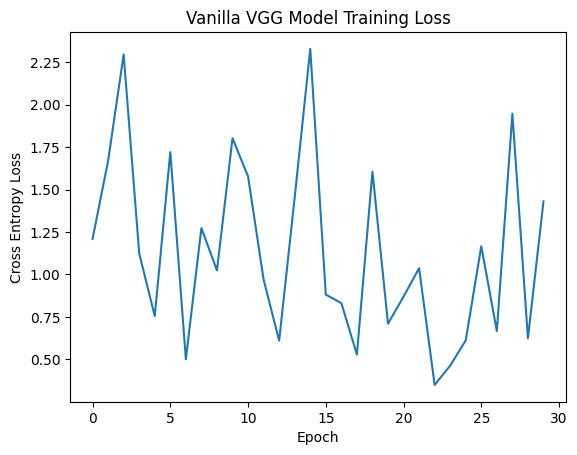

In [ ]:
# Plot Training Loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Vanilla VGG Model Training Loss');

##### Testing

In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)

        # Get prediction from max value
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions * 100
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

Accuracy on the test set: 36.96%


### 2. Classification with Data Augmented using Transformations



#### Data Augmentation

In [ ]:
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet norms
])

train_dataset = CustomDataset(input_data, target_data, transform=data_transform)

with open(path + 'pickle/train_dataset_transform.pickle', 'wb') as handle:
    pickle.dump(train_dataset, handle)

In [ ]:
with open(path + 'pickle/train_dataset_transform.pickle', 'rb') as handle:
    train_dataset_transform = pickle.load(handle)

In [ ]:
# Split 80% for training and 20% for testing
train_size = int(0.8 * len(train_dataset_transform))
test_size = len(train_dataset_transform) - train_size

torch.manual_seed(0)
train_data_transform, _ = random_split(train_dataset_transform, [train_size, test_size])

# create DataLoader
train_loader_transform = DataLoader(train_data_transform, batch_size=32, shuffle=True)

In [ ]:
with open(path + 'pickle/train_dataset_transform.pickle', 'rb') as handle:
    train_dataset_original = pickle.load(handle)

In [ ]:
# Split 80% for training and 20% for testing
train_size = int(0.8 * len(train_dataset_original))
test_size = len(train_dataset_original) - train_size

# Split the dataset
torch.manual_seed(0)
train_data_original, test_data_original = random_split(train_dataset_original, [train_size, test_size])

# create DataLoader
train_loader_original= DataLoader(train_data_original, batch_size=32, shuffle=True)
test_loader_original= DataLoader(test_data_original, batch_size=32, shuffle=False)

In [ ]:
def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v

#### ResNet

##### Training

In [ ]:
# Define model
model = ResNetModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


In [ ]:
# Training loop
num_epochs = 30
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(itr_merge(train_loader_original, train_loader_transform)):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[epoch] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/30], Loss: 2.4152
Epoch [2/30], Loss: 1.9121
Epoch [3/30], Loss: 1.2010
Epoch [4/30], Loss: 2.5597
Epoch [5/30], Loss: 2.9012
Epoch [6/30], Loss: 1.2534
Epoch [7/30], Loss: 1.1565
Epoch [8/30], Loss: 1.0861
Epoch [9/30], Loss: 2.3627
Epoch [10/30], Loss: 0.5720
Epoch [11/30], Loss: 0.3645
Epoch [12/30], Loss: 1.3886
Epoch [13/30], Loss: 1.3987
Epoch [14/30], Loss: 1.3040
Epoch [15/30], Loss: 1.4466
Epoch [16/30], Loss: 0.5002
Epoch [17/30], Loss: 2.0628
Epoch [18/30], Loss: 1.9555
Epoch [19/30], Loss: 0.8560
Epoch [20/30], Loss: 1.6170
Epoch [21/30], Loss: 0.8625
Epoch [22/30], Loss: 1.8246
Epoch [23/30], Loss: 1.7012
Epoch [24/30], Loss: 0.7827
Epoch [25/30], Loss: 0.7420
Epoch [26/30], Loss: 2.1797
Epoch [27/30], Loss: 0.6430
Epoch [28/30], Loss: 0.1581
Epoch [29/30], Loss: 1.8329
Epoch [30/30], Loss: 2.2177


In [ ]:
with open(path + 'pickle/c_transform_RN_model.pickle', 'wb') as handle:
    pickle.dump(model, handle)
with open(path + 'pickle/c_transform_RN_loss.pickle', 'wb') as handle:
    pickle.dump(losses, handle)

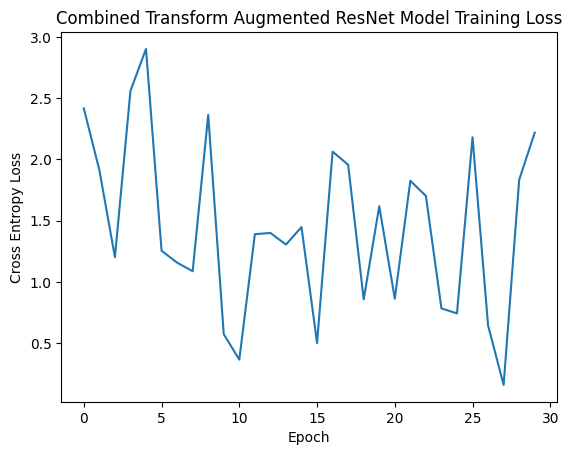

In [ ]:
# Plot Training Loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Combined Transform Augmented ResNet Model Training Loss');

##### Testing

In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader_original):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions * 100
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

Accuracy on the test set: 21.15%


#### VGG

##### Training

In [ ]:
# Define model
model = VGGModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 308MB/s]


In [ ]:
# Training loop
num_epochs = 30
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(itr_merge(train_loader_original, train_loader_transform)):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[epoch] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/30], Loss: 1.6261
Epoch [2/30], Loss: 1.7361
Epoch [3/30], Loss: 1.1694
Epoch [4/30], Loss: 1.0026
Epoch [5/30], Loss: 0.9336
Epoch [6/30], Loss: 1.0856
Epoch [7/30], Loss: 0.5263
Epoch [8/30], Loss: 1.2686
Epoch [9/30], Loss: 1.6675
Epoch [10/30], Loss: 1.0464
Epoch [11/30], Loss: 1.9959
Epoch [12/30], Loss: 1.5432
Epoch [13/30], Loss: 1.5585
Epoch [14/30], Loss: 1.2610
Epoch [15/30], Loss: 1.4186
Epoch [16/30], Loss: 0.9555
Epoch [17/30], Loss: 1.0337
Epoch [18/30], Loss: 1.4492
Epoch [19/30], Loss: 0.9851
Epoch [20/30], Loss: 0.5027
Epoch [21/30], Loss: 0.9208
Epoch [22/30], Loss: 1.5702
Epoch [23/30], Loss: 1.3043
Epoch [24/30], Loss: 1.4063
Epoch [25/30], Loss: 1.3032
Epoch [26/30], Loss: 1.0626
Epoch [27/30], Loss: 0.3606
Epoch [28/30], Loss: 1.2834
Epoch [29/30], Loss: 1.2227
Epoch [30/30], Loss: 2.0814


In [ ]:
with open(path + 'pickle/c_transform_VGG_model.pickle', 'wb') as handle:
    pickle.dump(model, handle)
with open(path + 'pickle/c_transform_VGG_loss.pickle', 'wb') as handle:
    pickle.dump(losses, handle)

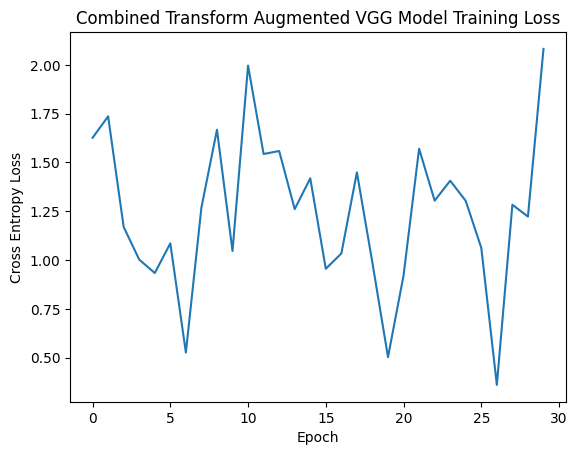

In [ ]:
# Plot Training Loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Combined Transform Augmented VGG Model Training Loss');

##### Testing

In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader_original):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions * 100
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

Accuracy on the test set: 18.77%


### 3. Classification using Data Augmented using DCGAN

#### DCGAN Model

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_channels, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, image):
        return self.main(image)[:, :, :384, :]


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(15, 1)


    def forward(self, image):
        output = self.main(image)
        output = output.view(output.shape[0], -1)
        output = self.fc(output)
        output = (output*.5) + 0.5
        return output


##### Cardboard

In [ ]:
with open(path + 'pickle/cardboard.pickle', 'rb') as handle:
    cardboard_data = pickle.load(handle)

In [ ]:
cardboard_data.shape

(403, 384, 512, 3)

In [ ]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
])

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx] / 255

        if self.transform:
            image = self.transform(image)

        return image.float()

In [ ]:
dataset = CustomDataset(cardboard_data, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def trainGAN(dataloader, generator, discriminator, optimG, optimD, criterion, epochs, fixed_noise):
    img_list = []
    iterations = 0
    generator_loss = []
    discriminator_loss = []

    for epoch in range(epochs):
        for i, images in enumerate(dataloader):
            images = images.to(device)

            noise = torch.randn(images.shape[0], noise_channels, 1, 1, device = device)

            # Step 1. Loss on real images from discriminator
            discriminator.zero_grad()
            real_labels = torch.full((images.shape[0], 1), 1., dtype = torch.float, device = device)

            outputD_Real = discriminator(images).view(-1, 1)
            if outputD_Real.min() < 0:
              print('small min: ', outputD_Real.min())
              print('max: ', outputD_Real.max())
              outputD_Real -= outputD_Real.min()
              outputD_Real /= outputD_Real.max()
            lossD_Real = criterion(outputD_Real, real_labels)
            lossD_Real.backward()

            # Step 2. Loss on generated image from discriminator
            fake_labels = torch.full((images.shape[0], 1), 0., dtype = torch.float, device = device)

            outputG_Fake = generator(noise)

            outputD_Fake = discriminator(outputG_Fake.detach()).view(-1, 1)
            if outputD_Fake.min() < 0:
              print('small min: ', outputD_Fake.min())
              print('max: ', outputD_Fake.max())
              outputD_Fake -= outputD_Fake.min()
              outputD_Fake /= outputD_Fake.max()
            lossD_Fake = criterion(outputD_Fake, fake_labels)
            lossD_Fake.backward()

            lossD = lossD_Real + lossD_Fake

            optimD.step()

            # Step 3. Loss on generated image from generator
            generator.zero_grad()
            real_labels = torch.full((images.shape[0], 1), 1., dtype = torch.float, device = device)

            outputGD_Fake = discriminator(outputG_Fake).view(-1, 1)
            if outputGD_Fake.min() < 0:
              print('small min: ', outputGD_Fake.min())
              print('max: ', outputGD_Fake.max())
              outputGD_Fake -= outputGD_Fake.min()
              outputGD_Fake /= outputGD_Fake.max()
            lossG = criterion(outputGD_Fake, real_labels)
            lossG.backward()

            optimG.step()

            if i % int(len(dataloader)/5) == 0:
                print(f"Epoch: {epoch} itr: {i}/{len(dataloader)}, DLoss: {round(lossD.item(), 5)}, GLoss: {round(lossG.item(), 5)}, {round(outputD_Real.mean().item(), 5)}, {round(outputD_Fake.mean().item(), 5)}, {round(outputGD_Fake.mean().item(), 5)}")


            generator_loss.append(lossG.item())
            discriminator_loss.append(lossD.item())
            if iterations % int(len(dataloader)*epochs/10) == 0:
                with torch.no_grad():
                    generated_samples = generator(fixed_noise).detach().cpu()
                    img_list.append(generated_samples)

            iterations += 1

    return generator_loss, discriminator_loss, img_list

In [ ]:
noise_channels = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
epochs = 20

optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_channels, 1, 1, device=device)

G_loss, D_loss, img_list = trainGAN(dataloader, generator, discriminator, optimizerG, optimizerD, criterion, epochs, fixed_noise)


# with open(path + 'pickle/DCGAN/cardboard/generator.pickle', 'wb') as handle:
#     pickle.dump(generator, handle)
# with open(path + 'pickle/DCGAN/cardboard/discriminator.pickle', 'wb') as handle:
#     pickle.dump(discriminator, handle)
# with open(path + 'pickle/DCGAN/cardboard/G_loss_35.pickle', 'wb') as handle:
#     pickle.dump(G_loss, handle)
# with open(path + 'pickle/DCGAN/cardboard/D_loss_35.pickle', 'wb') as handle:
#     pickle.dump(D_loss, handle)
# with open(path + 'pickle/DCGAN/cardboard/img_list_35.pickle', 'wb') as handle:
#     pickle.dump(img_list, handle)

Epoch: 0 itr: 0/13, DLoss: 1.39015, GLoss: 1.64163, 0.50979, 0.51014, 0.19541
Epoch: 0 itr: 2/13, DLoss: 1.38947, GLoss: 1.36536, 0.56206, 0.55118, 0.26111
Epoch: 0 itr: 4/13, DLoss: 1.13712, GLoss: 1.29002, 0.61592, 0.47205, 0.27666
Epoch: 0 itr: 6/13, DLoss: 1.02361, GLoss: 1.16477, 0.57682, 0.36579, 0.31221
Epoch: 0 itr: 8/13, DLoss: 0.77917, GLoss: 1.18596, 0.69913, 0.34046, 0.30546
Epoch: 0 itr: 10/13, DLoss: 0.6789, GLoss: 1.19068, 0.75864, 0.33055, 0.30402
Epoch: 0 itr: 12/13, DLoss: 0.63652, GLoss: 1.19665, 0.78277, 0.32288, 0.30221
Epoch: 1 itr: 0/13, DLoss: 0.59973, GLoss: 1.19619, 0.8025, 0.31583, 0.30235
Epoch: 1 itr: 2/13, DLoss: 0.59451, GLoss: 1.2306, 0.80849, 0.31733, 0.29216
Epoch: 1 itr: 4/13, DLoss: 0.56543, GLoss: 1.21594, 0.80858, 0.29728, 0.29643
Epoch: 1 itr: 6/13, DLoss: 0.55562, GLoss: 1.22116, 0.81463, 0.29569, 0.29489
Epoch: 1 itr: 8/13, DLoss: 0.54901, GLoss: 1.22615, 0.81829, 0.29421, 0.29342
Epoch: 1 itr: 10/13, DLoss: 0.54636, GLoss: 1.23096, 0.81882, 0.2

RuntimeError: ignored

In [ ]:
np.save(path + 'pickle/DCGAN/cardboard/img_list_35', img_list[-1])

##### Plastic

In [ ]:
with open(path + 'pickle/plastic.pickle', 'rb') as handle:
    plastic_data = pickle.load(handle)

In [ ]:
plastic_data.shape

(482, 384, 512, 3)

In [ ]:
dataset = CustomDataset(plastic_data, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
noise_channels = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
epochs = 20

optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_channels, 1, 1, device=device)

G_loss, D_loss, img_list = trainGAN(dataloader, generator, discriminator, optimizerG, optimizerD, criterion, epochs, fixed_noise)

np.save(path + 'pickle/DCGAN/plastic/img_list_35', img_list[-1])
# with open(path + 'pickle/DCGAN/plastic/generator.pickle', 'wb') as handle:
#     pickle.dump(generator, handle)
# with open(path + 'pickle/DCGAN/plastic/discriminator.pickle', 'wb') as handle:
#     pickle.dump(discriminator, handle)
# with open(path + 'pickle/DCGAN/plastic/img_list_35.pickle', 'wb') as handle:
#     pickle.dump(img_list, handle)
# with open(path + 'pickle/DCGAN/plastic/G_loss_35.pickle', 'wb') as handle:
#     pickle.dump(G_loss, handle)
# with open(path + 'pickle/DCGAN/plastic/D_loss_35.pickle', 'wb') as handle:
#     pickle.dump(D_loss, handle)

Epoch: 0 itr: 0/16, DLoss: 1.45673, GLoss: 1.72796, 0.37232, 0.37105, 0.17964
Epoch: 0 itr: 3/16, DLoss: 1.15407, GLoss: 1.50788, 0.54991, 0.42347, 0.22306
Epoch: 0 itr: 6/16, DLoss: 0.84024, GLoss: 1.29386, 0.60354, 0.28125, 0.27424
Epoch: 0 itr: 9/16, DLoss: 0.75309, GLoss: 1.28713, 0.65572, 0.28035, 0.27607
Epoch: 0 itr: 12/16, DLoss: 0.69375, GLoss: 1.28781, 0.69365, 0.27902, 0.27587
Epoch: 0 itr: 15/16, DLoss: 0.65779, GLoss: 1.29863, 0.71634, 0.27647, 0.27291
Epoch: 1 itr: 0/16, DLoss: 0.65325, GLoss: 1.2996, 0.71803, 0.27487, 0.27264
Epoch: 1 itr: 3/16, DLoss: 0.66092, GLoss: 1.30698, 0.71101, 0.27261, 0.27064
Epoch: 1 itr: 6/16, DLoss: 0.63064, GLoss: 1.31485, 0.73097, 0.2714, 0.26852
Epoch: 1 itr: 9/16, DLoss: 0.63669, GLoss: 1.32352, 0.7251, 0.27005, 0.2662
Epoch: 1 itr: 12/16, DLoss: 0.6249, GLoss: 1.33262, 0.73103, 0.26717, 0.26378
Epoch: 1 itr: 15/16, DLoss: 0.64872, GLoss: 1.34236, 0.70982, 0.26343, 0.26123
Epoch: 2 itr: 0/16, DLoss: 0.59438, GLoss: 1.34273, 0.74909, 0.26

In [ ]:
with open(path + 'pickle/DCGAN/plastic/img_list_35.pickle', 'wb') as handle:
    pickle.dump(img_list[-1], handle)

In [ ]:
np.save(path + 'pickle/DCGAN/plastic/img_list_35', img_list[-1])

##### Trash

In [ ]:
with open(path + 'pickle/trash.pickle', 'rb') as handle:
    trash_data = pickle.load(handle)

In [ ]:
trash_data.shape

(137, 384, 512, 3)

In [ ]:
dataset = CustomDataset(trash_data, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
noise_channels = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
epochs = 20

optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_channels, 1, 1, device=device)

G_loss, D_loss, img_list = trainGAN(dataloader, generator, discriminator, optimizerG, optimizerD, criterion, epochs, fixed_noise)

np.save(path + 'pickle/DCGAN/trash/img_list_35', img_list[-1])
# with open(path + 'pickle/DCGAN/trash/generator.pickle', 'wb') as handle:
#     pickle.dump(generator, handle)
# with open(path + 'pickle/DCGAN/trash/discriminator.pickle', 'wb') as handle:
#     pickle.dump(discriminator, handle)
# with open(path + 'pickle/DCGAN/trash/img_list_35.pickle', 'wb') as handle:
#     pickle.dump(img_list, handle)
# with open(path + 'pickle/DCGAN/trash/G_loss_35.pickle', 'wb') as handle:
#     pickle.dump(G_loss, handle)
# with open(path + 'pickle/DCGAN/trash/D_loss_35.pickle', 'wb') as handle:
#     pickle.dump(D_loss, handle)

Epoch: 0 itr: 0/5, DLoss: 1.40528, GLoss: 1.44457, 0.41514, 0.40655, 0.23776
Epoch: 0 itr: 1/5, DLoss: 1.08957, GLoss: 1.45103, 0.59772, 0.43204, 0.23575
Epoch: 0 itr: 2/5, DLoss: 1.02719, GLoss: 1.45956, 0.59974, 0.39199, 0.23321
Epoch: 0 itr: 3/5, DLoss: 0.80027, GLoss: 1.29857, 0.66048, 0.3053, 0.273
Epoch: 0 itr: 4/5, DLoss: 0.70057, GLoss: 1.27939, 0.70573, 0.28884, 0.27821
Epoch: 1 itr: 0/5, DLoss: 0.59863, GLoss: 1.28159, 0.77264, 0.28333, 0.2776
Epoch: 1 itr: 1/5, DLoss: 0.5572, GLoss: 1.28391, 0.80163, 0.28081, 0.27696
Epoch: 1 itr: 2/5, DLoss: 0.54177, GLoss: 1.28531, 0.81401, 0.28051, 0.27657
Epoch: 1 itr: 3/5, DLoss: 0.55281, GLoss: 1.28716, 0.80431, 0.28089, 0.27606
Epoch: 1 itr: 4/5, DLoss: 0.57853, GLoss: 1.29064, 0.78702, 0.2838, 0.2751
Epoch: 2 itr: 0/5, DLoss: 0.52226, GLoss: 1.29362, 0.83786, 0.2898, 0.27428
Epoch: 2 itr: 1/5, DLoss: 0.5132, GLoss: 1.30139, 0.84683, 0.29119, 0.27215
Epoch: 2 itr: 2/5, DLoss: 0.47762, GLoss: 1.30695, 0.86699, 0.28329, 0.27065
Epoch: 2

##### Glass

In [ ]:
with open(path + 'pickle/glass.pickle', 'rb') as handle:
    glass_data = pickle.load(handle)

In [ ]:
glass_data.shape

(501, 384, 512, 3)

In [ ]:
dataset = CustomDataset(glass_data, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
noise_channels = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
epochs = 20

optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_channels, 1, 1, device=device)

G_loss, D_loss, img_list = trainGAN(dataloader, generator, discriminator, optimizerG, optimizerD, criterion, epochs, fixed_noise)

np.save(path + 'pickle/DCGAN/glass/img_list_35', img_list[-1])
# with open(path + 'pickle/DCGAN/glass/generator.pickle', 'wb') as handle:
#     pickle.dump(generator, handle)
# with open(path + 'pickle/DCGAN/glass/discriminator.pickle', 'wb') as handle:
#     pickle.dump(discriminator, handle)
# with open(path + 'pickle/DCGAN/glass/img_list_35.pickle', 'wb') as handle:
#     pickle.dump(img_list, handle)
# with open(path + 'pickle/DCGAN/glass/G_loss_35.pickle', 'wb') as handle:
#     pickle.dump(G_loss, handle)
# with open(path + 'pickle/DCGAN/glass/D_loss_35.pickle', 'wb') as handle:
#     pickle.dump(D_loss, handle)

Epoch: 0 itr: 0/16, DLoss: 1.3961, GLoss: 1.15279, 0.54865, 0.54788, 0.31615
Epoch: 0 itr: 3/16, DLoss: 1.30355, GLoss: 0.68041, 0.58804, 0.53733, 0.50641
Epoch: 0 itr: 6/16, DLoss: 1.15511, GLoss: 0.68091, 0.6416, 0.50791, 0.50616
Epoch: 0 itr: 9/16, DLoss: 1.0379, GLoss: 0.68463, 0.71807, 0.50603, 0.50428
Epoch: 0 itr: 12/16, DLoss: 0.97779, GLoss: 0.68911, 0.76407, 0.5073, 0.50202
Epoch: 0 itr: 15/16, DLoss: 0.93865, GLoss: 0.6965, 0.78782, 0.50333, 0.49833
Epoch: 1 itr: 0/16, DLoss: 0.91825, GLoss: 0.69897, 0.80105, 0.50153, 0.4971
Epoch: 1 itr: 3/16, DLoss: 0.89877, GLoss: 0.70547, 0.80915, 0.49679, 0.49388
Epoch: 1 itr: 6/16, DLoss: 0.89613, GLoss: 0.71122, 0.80844, 0.49504, 0.49104
Epoch: 1 itr: 9/16, DLoss: 0.87191, GLoss: 0.71758, 0.82012, 0.49007, 0.48793
Epoch: 1 itr: 12/16, DLoss: 0.87059, GLoss: 0.72318, 0.82029, 0.48943, 0.48521
Epoch: 1 itr: 15/16, DLoss: 0.86077, GLoss: 0.72961, 0.81955, 0.48392, 0.4821
Epoch: 2 itr: 0/16, DLoss: 0.85789, GLoss: 0.73137, 0.82019, 0.4828

##### Metal

In [ ]:
with open(path + 'pickle/metal.pickle', 'rb') as handle:
    metal_data = pickle.load(handle)

In [ ]:
metal_data.shape

(410, 384, 512, 3)

In [ ]:
dataset = CustomDataset(metal_data, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
noise_channels = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
epochs = 20

optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_channels, 1, 1, device=device)

G_loss, D_loss, img_list = trainGAN(dataloader, generator, discriminator, optimizerG, optimizerD, criterion, epochs, fixed_noise)


np.save(path + 'pickle/DCGAN/metal/img_list_35', img_list[-1])
# with open(path + 'pickle/DCGAN/metal/generator.pickle', 'wb') as handle:
#     pickle.dump(generator, handle)
# with open(path + 'pickle/DCGAN/metal/discriminator.pickle', 'wb') as handle:
#     pickle.dump(discriminator, handle)
# with open(path + 'pickle/DCGAN/metal/img_list_35.pickle', 'wb') as handle:
#     pickle.dump(img_list, handle)
# with open(path + 'pickle/DCGAN/metal/G_loss_35.pickle', 'wb') as handle:
#     pickle.dump(G_loss, handle)
# with open(path + 'pickle/DCGAN/metal/D_loss_35.pickle', 'wb') as handle:
#     pickle.dump(D_loss, handle)

Epoch: 0 itr: 0/13, DLoss: 1.45667, GLoss: 1.44567, 0.38013, 0.38569, 0.23588
Epoch: 0 itr: 2/13, DLoss: 1.27466, GLoss: 1.07764, 0.50517, 0.44223, 0.34085
Epoch: 0 itr: 4/13, DLoss: 1.14272, GLoss: 0.96885, 0.55245, 0.41865, 0.37963
Epoch: 0 itr: 6/13, DLoss: 1.09182, GLoss: 0.93791, 0.57629, 0.4149, 0.39153
Epoch: 0 itr: 8/13, DLoss: 1.06283, GLoss: 0.9236, 0.58326, 0.4049, 0.39709
Epoch: 0 itr: 10/13, DLoss: 0.98997, GLoss: 0.91637, 0.62446, 0.40414, 0.39997
Epoch: 0 itr: 12/13, DLoss: 0.95336, GLoss: 0.91585, 0.64852, 0.40543, 0.40018
Epoch: 1 itr: 0/13, DLoss: 0.93461, GLoss: 0.9159, 0.66105, 0.40559, 0.40016
Epoch: 1 itr: 2/13, DLoss: 0.92247, GLoss: 0.91617, 0.66694, 0.40386, 0.40005
Epoch: 1 itr: 4/13, DLoss: 0.91329, GLoss: 0.9169, 0.67253, 0.40342, 0.39976
Epoch: 1 itr: 6/13, DLoss: 0.90604, GLoss: 0.91894, 0.67605, 0.4022, 0.39894
Epoch: 1 itr: 8/13, DLoss: 0.90054, GLoss: 0.91869, 0.67818, 0.40076, 0.39904
Epoch: 1 itr: 10/13, DLoss: 0.89724, GLoss: 0.91854, 0.68121, 0.4014

##### Paper

In [ ]:
with open(path + 'pickle/paper.pickle', 'rb') as handle:
    paper_data = pickle.load(handle)

In [ ]:
paper_data.shape

(594, 384, 512, 3)

In [ ]:
dataset = CustomDataset(paper_data, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
noise_channels = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
epochs = 35

optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_channels, 1, 1, device=device)

G_loss, D_loss, img_list = trainGAN(dataloader, generator, discriminator, optimizerG, optimizerD, criterion, epochs, fixed_noise)


with open(path + 'pickle/DCGAN/paper/generator.pickle', 'wb') as handle:
    pickle.dump(generator, handle)
with open(path + 'pickle/DCGAN/paper/discriminator.pickle', 'wb') as handle:
    pickle.dump(discriminator, handle)
with open(path + 'pickle/DCGAN/paper/img_list_35.pickle', 'wb') as handle:
    pickle.dump(img_list, handle)
with open(path + 'pickle/DCGAN/paper/G_loss_35.pickle', 'wb') as handle:
    pickle.dump(G_loss, handle)
with open(path + 'pickle/DCGAN/paper/D_loss_35.pickle', 'wb') as handle:
    pickle.dump(D_loss, handle)

Epoch: 0 itr: 0/19, DLoss: 1.49748, GLoss: 0.98333, 0.65803, 0.65886, 0.37434
Epoch: 0 itr: 3/19, DLoss: 0.9349, GLoss: 0.80509, 0.79475, 0.50146, 0.44712
Epoch: 0 itr: 6/19, DLoss: 0.78434, GLoss: 0.79244, 0.89475, 0.48777, 0.45277


RuntimeError: ignored

#### Combine Data

In [ ]:
with open(path + 'pickle/DCGAN/cardboard/img_list_35.pickle', 'rb') as handle:
    cardboard_data = pickle.load(handle)
glass_data = np.load(path + 'pickle/DCGAN/glass/img_list_35.npy')
metal_data = np.load(path + 'pickle/DCGAN/metal/img_list_35.npy')
with open(path + 'pickle/DCGAN/paper/img_list_30.pickle', 'rb') as handle:
    paper_data = pickle.load(handle)
with open(path + 'pickle/DCGAN/plastic/img_list_35.pickle', 'rb') as handle:
    plastic_data = pickle.load(handle)
trash_data = np.load(path + 'pickle/DCGAN/trash/img_list_35.npy')

In [ ]:
l1 = torch.full((64, 1), 0., dtype = torch.float, device = device)
l2 = torch.full((64, 1), 1., dtype = torch.float, device = device)
l3 = torch.full((64, 1), 2., dtype = torch.float, device = device)
l4 = torch.full((64, 1), 3., dtype = torch.float, device = device)
l5 = torch.full((64, 1), 4., dtype = torch.float, device = device)
l6 = torch.full((64, 1), 5., dtype = torch.float, device = device)

In [ ]:
DCGAN_labels = torch.cat((l1,l2,l3,l4,l5,l6), 0)
DCGAN_data = torch.cat((cardboard_data[-1],torch.from_numpy(glass_data),torch.from_numpy(metal_data),paper_data[-1],plastic_data,torch.from_numpy(trash_data)), 0)

In [ ]:
class DCGANDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data.float()
        self.target = target.float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]*2.5
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

DCGAN_train_dataset = DCGANDataset(DCGAN_data, DCGAN_labels)

In [ ]:
with open(path + 'pickle/DCGAN_train_dataset.pickle', 'wb') as handle:
  pickle.dump(DCGAN_train_dataset, handle)

In [ ]:
with open(path + 'pickle/DCGAN_train_dataset.pickle', 'rb') as handle:
    DCGAN_train_dataset = pickle.load(handle)

In [ ]:
# Split 80% for training and 20% for testing
train_size = int(0.8 * len(DCGAN_train_dataset))
test_size = len(DCGAN_train_dataset) - train_size

torch.manual_seed(0)
train_data_DCGAN, _ = random_split(DCGAN_train_dataset, [train_size, test_size])

# create DataLoader
train_loader_DCGAN = DataLoader(train_data_DCGAN, batch_size=32, shuffle=True)

In [ ]:
with open(path + 'pickle/train_dataset.pickle', 'rb') as handle:
    train_dataset_original = pickle.load(handle)

In [ ]:
# Split 80% for training and 20% for testing
train_size = int(0.8 * len(train_dataset_original))
test_size = len(train_dataset_original) - train_size

torch.manual_seed(0)
train_data_original, test_data_original = random_split(train_dataset_original, [train_size, test_size])

# create DataLoader
train_loader_original= DataLoader(train_data_original, batch_size=32, shuffle=True)
test_loader_original= DataLoader(test_data_original, batch_size=32, shuffle=False)

In [ ]:
def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v

#### ResNet

##### Training

In [ ]:
# Define model
model = ResNetModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 20
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(itr_merge(train_loader_original, train_loader_DCGAN)):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[epoch] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 1.2235
Epoch [2/20], Loss: 1.3542
Epoch [3/20], Loss: 1.2668
Epoch [4/20], Loss: 1.0980
Epoch [5/20], Loss: 0.6985
Epoch [6/20], Loss: 1.0199
Epoch [7/20], Loss: 0.5636
Epoch [8/20], Loss: 1.5346
Epoch [9/20], Loss: 0.6757
Epoch [10/20], Loss: 0.3339
Epoch [11/20], Loss: 0.1334
Epoch [12/20], Loss: 0.2936
Epoch [13/20], Loss: 0.1607
Epoch [14/20], Loss: 0.5958
Epoch [15/20], Loss: 0.3449
Epoch [16/20], Loss: 1.3287
Epoch [17/20], Loss: 0.2311
Epoch [18/20], Loss: 0.8356
Epoch [19/20], Loss: 0.3082
Epoch [20/20], Loss: 0.3413


In [ ]:
with open(path + 'pickle/c_DCGAN_RN_model.pickle_new', 'wb') as handle:
    pickle.dump(model, handle)
with open(path + 'pickle/c_DCGAN_RN_loss.pickle_new', 'wb') as handle:
    pickle.dump(losses, handle)

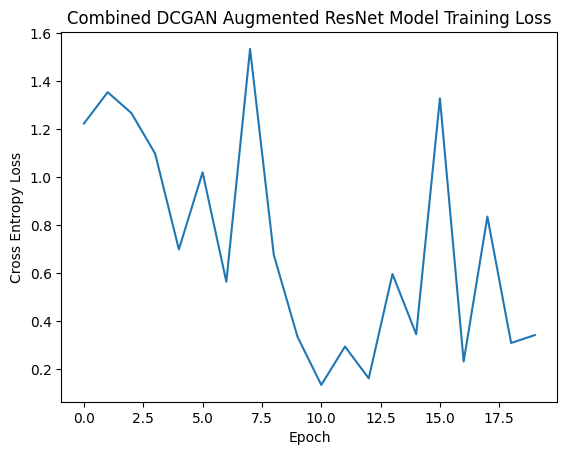

In [ ]:
# Plot Training Loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Combined DCGAN Augmented ResNet Model Training Loss');

##### Testing

In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader_original):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions * 100
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

Accuracy on the test set: 17.00%


#### VGG

##### Training

In [ ]:
# Define model
model = VGGModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 10
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(itr_merge(train_loader_original, train_loader_DCGAN)):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[epoch] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 1.3619
Epoch [2/10], Loss: 0.9223
Epoch [3/10], Loss: 1.2727
Epoch [4/10], Loss: 0.7904
Epoch [5/10], Loss: 1.6325
Epoch [6/10], Loss: 0.6814
Epoch [7/10], Loss: 1.0637
Epoch [8/10], Loss: 0.9995
Epoch [9/10], Loss: 0.5033
Epoch [10/10], Loss: 0.5795


In [ ]:
with open(path + 'pickle/c_DCGAN_VGG_model.pickle_new', 'wb') as handle:
    pickle.dump(model, handle)
with open(path + 'pickle/c_DCGAN_VGG_loss.pickle_new', 'wb') as handle:
    pickle.dump(losses, handle)

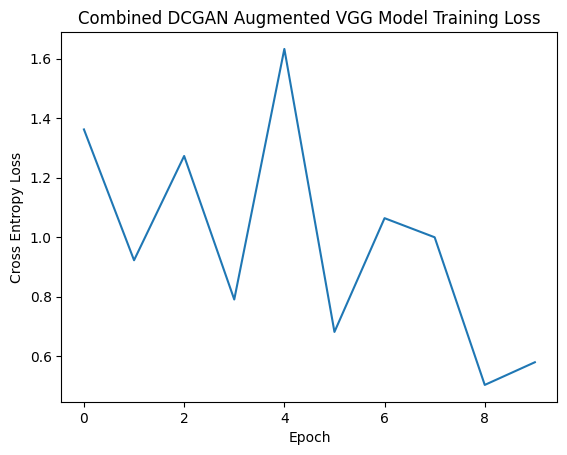

In [ ]:
# Plot Training Loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Combined DCGAN Augmented VGG Model Training Loss');

##### Testing

In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader_original):
        images = images.to(device)
        labels = labels.reshape(-1).type(torch.LongTensor).to(device)

        # Forward pass
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions * 100
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

Accuracy on the test set: 34.98%


#### DCGAN Loss Plots

In [ ]:
with open(path + 'pickle/DCGAN/metal/D_loss_35.pickle', 'rb') as handle:
    metalD = pickle.load(handle)
with open(path + 'pickle/DCGAN/metal/G_loss_35.pickle', 'rb') as handle:
    metalG = pickle.load(handle)

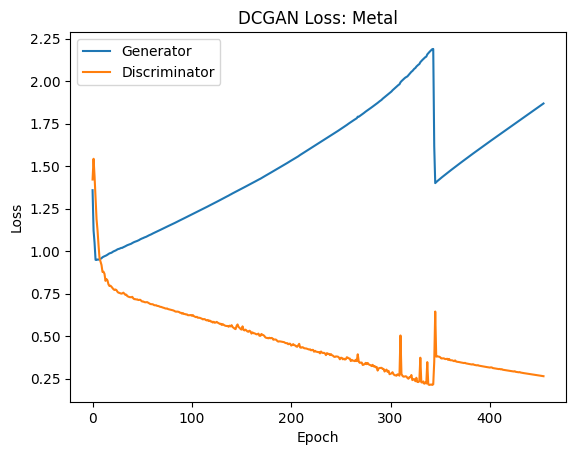

In [ ]:
plt.plot(metalG)
plt.plot(metalD)
plt.title('DCGAN Loss: Metal')
plt.legend(['Generator','Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
with open(path + 'pickle/DCGAN/cardboard/D_loss_35.pickle', 'rb') as handle:
    metalD = pickle.load(handle)
with open(path + 'pickle/DCGAN/cardboard/G_loss_35.pickle', 'rb') as handle:
    metalG = pickle.load(handle)

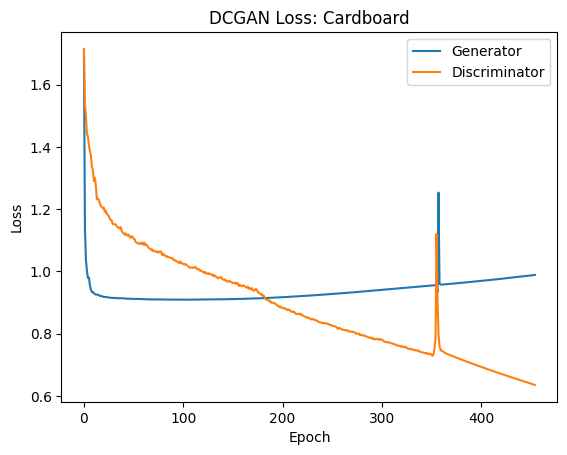

In [ ]:
plt.plot(metalG)
plt.plot(metalD)
plt.title('DCGAN Loss: Cardboard')
plt.legend(['Generator','Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
with open(path + 'pickle/DCGAN/glass/D_loss_35.pickle', 'rb') as handle:
    metalD = pickle.load(handle)
with open(path + 'pickle/DCGAN/glass/G_loss_35.pickle', 'rb') as handle:
    metalG = pickle.load(handle)

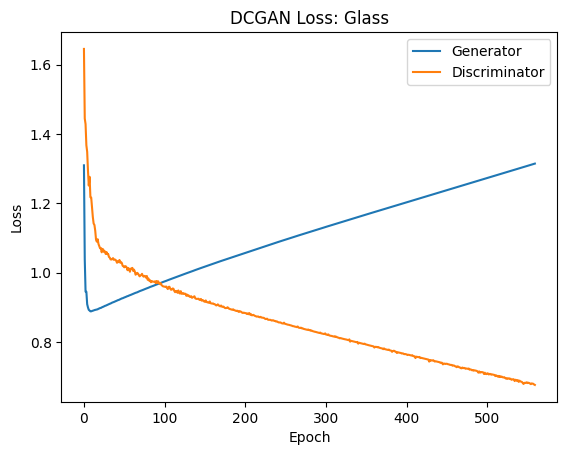

In [ ]:
plt.plot(metalG)
plt.plot(metalD)
plt.title('DCGAN Loss: Glass')
plt.legend(['Generator','Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
with open(path + 'pickle/DCGAN/paper/D_loss_30.pickle', 'rb') as handle:
    metalD = pickle.load(handle)
with open(path + 'pickle/DCGAN/paper/G_loss_30.pickle', 'rb') as handle:
    metalG = pickle.load(handle)

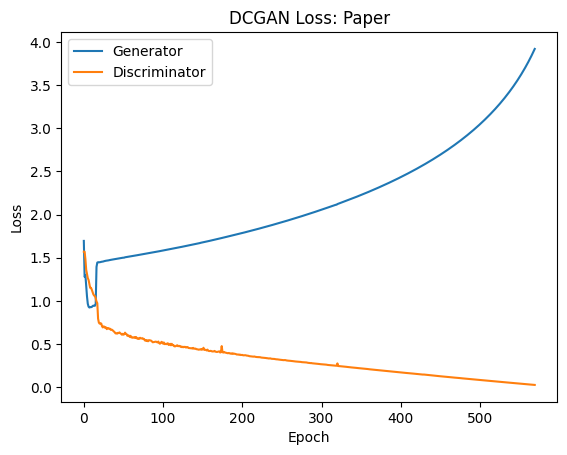

In [ ]:
plt.plot(metalG)
plt.plot(metalD)
plt.title('DCGAN Loss: Paper')
plt.legend(['Generator','Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
with open(path + 'pickle/DCGAN/plastic/D_loss_35.pickle', 'rb') as handle:
    metalD = pickle.load(handle)
with open(path + 'pickle/DCGAN/plastic/G_loss_35.pickle', 'rb') as handle:
    metalG = pickle.load(handle)

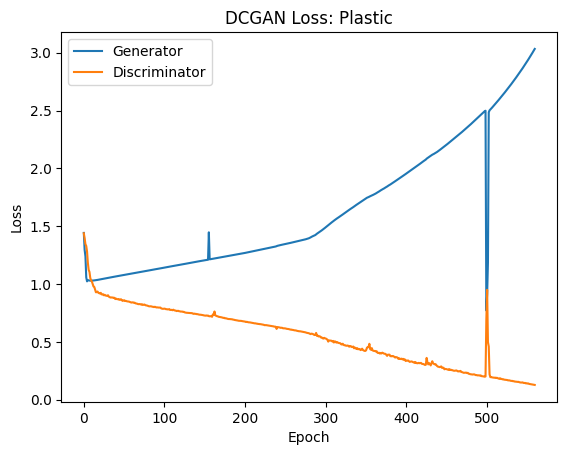

In [ ]:
plt.plot(metalG)
plt.plot(metalD)
plt.title('DCGAN Loss: Plastic')
plt.legend(['Generator','Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
with open(path + 'pickle/DCGAN/trash/D_loss_35.pickle', 'rb') as handle:
    metalD = pickle.load(handle)
with open(path + 'pickle/DCGAN/trash/G_loss_35.pickle', 'rb') as handle:
    metalG = pickle.load(handle)

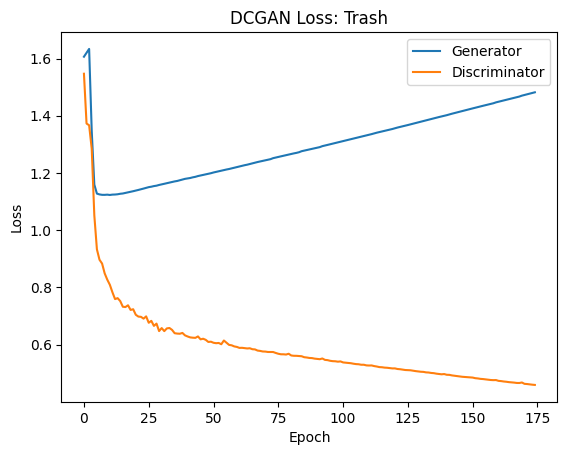

In [ ]:
plt.plot(metalG)
plt.plot(metalD)
plt.title('DCGAN Loss: Trash')
plt.legend(['Generator','Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss');